In [26]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, InputLayer, Dropout

# utilities
import joblib


In [27]:
#Load dataset 
df = pd.read_csv("Heart_disease_cleveland_new.csv")  
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [28]:
df.columns


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [29]:

print(df.shape)
print(df.isnull().sum())
df.describe().T


(303, 14)
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,2.158416,0.960126,0.0,2.0,2.0,3.0,3.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [30]:
# Impute numeric missing with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [31]:
# Features and labels
X = df.drop(columns=['target'])
y = df['target']

cat_cols = ['cp','restecg','slope','thal','ca']  
cat_cols = [c for c in cat_cols if c in X.columns]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X.shape, y.shape


((303, 20), (303,))

In [32]:
# Standardize features 
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [33]:
# Metrics utilities 
def calc_from_confusion(cm):
    TP, FN = cm[0][0], cm[0][1]
    FP, TN = cm[1][0], cm[1][1]
    eps = 1e-10
    TPR = TP / (TP + FN + eps)
    TNR = TN / (TN + FP + eps)
    FPR = FP / (TN + FP + eps)
    FNR = FN / (TP + FN + eps)
    Precision = TP / (TP + FP + eps)
    F1 = 2 * TP / (2 * TP + FP + FN + eps)
    Accuracy = (TP + TN) / (TP + TN + FP + FN + eps)
    Error_rate = (FP + FN) / (TP + TN + FP + FN + eps)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP*TN - FP*FN) / (((TP+FN)*(FN+TN) + (TP+FP)*(FP+TN)) + eps)
    return {
        'TP':TP,'TN':TN,'FP':FP,'FN':FN,
        'TPR':TPR,'TNR':TNR,'FPR':FPR,'FNR':FNR,
        'Precision':Precision,'F1':F1,'Accuracy':Accuracy,'Error_rate':Error_rate,
        'BACC':BACC,'TSS':TSS,'HSS':HSS
    }

def brier_skill_score(brier, brier_ref):
    eps=1e-10
    return 1.0 - (brier / (brier_ref + eps))


In [34]:
# Stratified K-Fold setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# placeholders for per-fold metrics
rf_results = []
svm_results = []
gru_results = []


In [35]:
# GridSearch for RF and SVM
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators':[50,100,150], 'min_samples_split':[2,4,6]}

svm = SVC(probability=True)
svm_params = {'C':[0.1,1,3], 'kernel':['linear']}

grid_rf = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
grid_rf.fit(X_scaled, y)
print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

grid_svm = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1)
grid_svm.fit(X_scaled, y)
print("Best SVM params:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_


Best RF params: {'min_samples_split': 6, 'n_estimators': 100}
Best SVM params: {'C': 0.1, 'kernel': 'linear'}


In [36]:
joblib.dump(best_rf, "best_rf.joblib")
joblib.dump(best_svm, "best_svm.joblib")


['best_svm.joblib']

In [37]:
#  CV loop
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

# reference brier for BSS: probability climatology (mean of y)
brier_ref = brier_score_loss(y, np.full_like(y, y.mean(), dtype=float))

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Random Forest
    rf_m = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
    rf_m.fit(X_train, y_train)
    rf_prob = rf_m.predict_proba(X_test)[:,1]
    rf_pred = (rf_prob > 0.5).astype(int)
    cm_rf = confusion_matrix(y_test, rf_pred, labels=[1,0])
    rf_metrics = calc_from_confusion(cm_rf)
    rf_brier = brier_score_loss(y_test, rf_prob)
    rf_auc = roc_auc_score(y_test, rf_prob)
    rf_metrics.update({'Brier':rf_brier, 'AUC':rf_auc, 'BSS': brier_skill_score(rf_brier, brier_ref)})
    rf_results.append(rf_metrics)
    
    # SVM
    svm_m = SVC(**grid_svm.best_params_, probability=True)
    svm_m.fit(X_train, y_train)
    svm_prob = svm_m.predict_proba(X_test)[:,1]
    svm_pred = (svm_prob > 0.5).astype(int)
    cm_svm = confusion_matrix(y_test, svm_pred, labels=[1,0])
    svm_metrics = calc_from_confusion(cm_svm)
    svm_brier = brier_score_loss(y_test, svm_prob)
    svm_auc = roc_auc_score(y_test, svm_prob)
    svm_metrics.update({'Brier':svm_brier, 'AUC':svm_auc, 'BSS': brier_skill_score(svm_brier, brier_ref)})
    svm_results.append(svm_metrics)
    
    # GRU model
  
    tf.keras.backend.clear_session()
    input_shape = (X_train.shape[1], 1)
    gru_model = Sequential()
    gru_model.add(InputLayer(input_shape=input_shape))
    gru_model.add(GRU(32, activation='tanh', return_sequences=False))
    gru_model.add(Dropout(0.2))
    gru_model.add(Dense(1, activation='sigmoid'))
    gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # reshape to (samples, timesteps, channels) -> here we use (n_features, 1) timesteps
    Xtr = X_train.to_numpy().reshape(len(X_train), X_train.shape[1], 1)
    Xte = X_test.to_numpy().reshape(len(X_test), X_test.shape[1], 1)
    
    gru_model.fit(Xtr, y_train.to_numpy(), epochs=30, batch_size=16, validation_data=(Xte, y_test.to_numpy()), verbose=0)
    gru_prob = gru_model.predict(Xte).ravel()
    gru_pred = (gru_prob > 0.5).astype(int)
    cm_gru = confusion_matrix(y_test, gru_pred, labels=[1,0])
    gru_metrics = calc_from_confusion(cm_gru)
    gru_brier = brier_score_loss(y_test, gru_prob)
    gru_auc = roc_auc_score(y_test, gru_prob)
    gru_metrics.update({'Brier':gru_brier, 'AUC':gru_auc, 'BSS': brier_skill_score(gru_brier, brier_ref)})
    gru_results.append(gru_metrics)
    
    print(f"Fold {fold} done.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 1 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 2 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 3 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 4 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 5 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 6 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 7 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 8 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 9 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 10 done.


In [38]:
#  Convert to DataFrame and average metrics
def results_to_df(results_list):
    return pd.DataFrame(results_list).T

rf_df = pd.DataFrame(rf_results)
svm_df = pd.DataFrame(svm_results)
gru_df = pd.DataFrame(gru_results)

# Show per-fold metrics (rounded)
print("Random Forest per-fold (first 5 cols):")
display(rf_df.round(3))
print("Averages:")
display(rf_df.mean().round(3))

print("SVM per-fold:")
display(svm_df.round(3))
print("Averages:")
display(svm_df.mean().round(3))

print("GRU per-fold:")
display(gru_df.round(3))
print("Averages:")
display(gru_df.mean().round(3))


Random Forest per-fold (first 5 cols):


,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1,Accuracy,Error_rate,BACC,TSS,HSS,Brier,AUC,BSS
0,12,14,3,2,0.857,0.824,0.176,0.143,0.800,0.828,0.839,0.161,0.840,0.681,0.676,0.134,0.899,0.460
1,11,17,0,3,0.786,1.000,0.000,0.214,1.000,0.880,0.903,0.097,0.893,0.786,0.801,0.099,0.954,0.599
2,12,12,5,2,0.857,0.706,0.294,0.143,0.706,0.774,0.774,0.226,0.782,0.563,0.553,0.154,0.878,0.381
3,9,13,4,4,0.692,0.765,0.235,0.308,0.692,0.692,0.733,0.267,0.729,0.457,0.457,0.149,0.878,0.400
4,13,11,5,1,0.929,0.687,0.312,0.071,0.722,0.812,0.800,0.200,0.808,0.616,0.605,0.143,0.906,0.426
5,7,14,2,7,0.500,0.875,0.125,0.500,0.778,0.609,0.700,0.300,0.687,0.375,0.384,0.162,0.853,0.348
6,11,15,1,3,0.786,0.937,0.062,0.214,0.917,0.846,0.867,0.133,0.862,0.723,0.730,0.100,0.960,0.598
7,9,12,4,5,0.643,0.750,0.250,0.357,0.692,0.667,0.700,0.300,0.696,0.393,0.395,0.160,0.857,0.355
8,11,16,0,3,0.786,1.000,0.000,0.214,1.000,0.880,0.900,0.100,0.893,0.786,0.796,0.103,0.951,0.583
9,10,14,2,4,0.714,0.875,0.125,0.286,0.833,0.769,0.800,0.200,0.795,0.589,0.595,0.145,0.897,0.417


Averages:


TP            10.500
TN            13.800
FP             2.600
FN             3.400
TPR            0.755
TNR            0.842
FPR            0.158
FNR            0.245
Precision      0.814
F1             0.776
Accuracy       0.802
Error_rate     0.198
BACC           0.798
TSS            0.597
HSS            0.599
Brier          0.135
AUC            0.903
BSS            0.457
dtype: float64

SVM per-fold:


,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1,Accuracy,Error_rate,BACC,TSS,HSS,Brier,AUC,BSS
0,10,15,2,4,0.714,0.882,0.118,0.286,0.833,0.769,0.806,0.194,0.798,0.597,0.604,0.125,0.903,0.496
1,12,16,1,2,0.857,0.941,0.059,0.143,0.923,0.889,0.903,0.097,0.899,0.798,0.803,0.084,0.962,0.664
2,11,14,3,3,0.786,0.824,0.176,0.214,0.786,0.786,0.806,0.194,0.805,0.609,0.609,0.134,0.878,0.461
3,11,15,2,2,0.846,0.882,0.118,0.154,0.846,0.846,0.867,0.133,0.864,0.729,0.729,0.125,0.914,0.496
4,12,11,5,2,0.857,0.687,0.312,0.143,0.706,0.774,0.767,0.233,0.772,0.545,0.537,0.120,0.920,0.515
5,9,13,3,5,0.643,0.812,0.187,0.357,0.750,0.692,0.733,0.267,0.728,0.455,0.459,0.153,0.871,0.385
6,10,16,0,4,0.714,1.000,0.000,0.286,1.000,0.833,0.867,0.133,0.857,0.714,0.727,0.097,0.955,0.610
7,9,12,4,5,0.643,0.750,0.250,0.357,0.692,0.667,0.700,0.300,0.696,0.393,0.395,0.154,0.871,0.378
8,12,14,2,2,0.857,0.875,0.125,0.143,0.857,0.857,0.867,0.133,0.866,0.732,0.732,0.089,0.924,0.643
9,10,14,2,4,0.714,0.875,0.125,0.286,0.833,0.769,0.800,0.200,0.795,0.589,0.595,0.151,0.866,0.393


Averages:


TP            10.600
TN            14.000
FP             2.400
FN             3.300
TPR            0.763
TNR            0.853
FPR            0.147
FNR            0.237
Precision      0.823
F1             0.788
Accuracy       0.812
Error_rate     0.188
BACC           0.808
TSS            0.616
HSS            0.619
Brier          0.123
AUC            0.906
BSS            0.504
dtype: float64

GRU per-fold:


,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1,Accuracy,Error_rate,BACC,TSS,HSS,Brier,AUC,BSS
0,12,15,2,2,0.857,0.882,0.118,0.143,0.857,0.857,0.871,0.129,0.870,0.739,0.739,0.105,0.933,0.576
1,13,16,1,1,0.929,0.941,0.059,0.071,0.929,0.929,0.935,0.065,0.935,0.870,0.870,0.090,0.937,0.637
2,10,12,5,4,0.714,0.706,0.294,0.286,0.667,0.690,0.710,0.290,0.710,0.420,0.418,0.167,0.857,0.328
3,8,15,2,5,0.615,0.882,0.118,0.385,0.800,0.696,0.767,0.233,0.749,0.498,0.512,0.123,0.910,0.503
4,11,14,2,3,0.786,0.875,0.125,0.214,0.846,0.815,0.833,0.167,0.830,0.661,0.664,0.114,0.906,0.542
5,9,13,3,5,0.643,0.812,0.187,0.357,0.750,0.692,0.733,0.267,0.728,0.455,0.459,0.159,0.844,0.358
6,11,14,2,3,0.786,0.875,0.125,0.214,0.846,0.815,0.833,0.167,0.830,0.661,0.664,0.117,0.911,0.531
7,9,12,4,5,0.643,0.750,0.250,0.357,0.692,0.667,0.700,0.300,0.696,0.393,0.395,0.169,0.830,0.318
8,10,14,2,4,0.714,0.875,0.125,0.286,0.833,0.769,0.800,0.200,0.795,0.589,0.595,0.122,0.888,0.510
9,8,14,2,6,0.571,0.875,0.125,0.429,0.800,0.667,0.733,0.267,0.723,0.446,0.455,0.158,0.862,0.364


Averages:


TP            10.100
TN            13.900
FP             2.500
FN             3.800
TPR            0.726
TNR            0.847
FPR            0.153
FNR            0.274
Precision      0.802
F1             0.760
Accuracy       0.792
Error_rate     0.208
BACC           0.787
TSS            0.573
HSS            0.577
Brier          0.132
AUC            0.888
BSS            0.467
dtype: float64

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


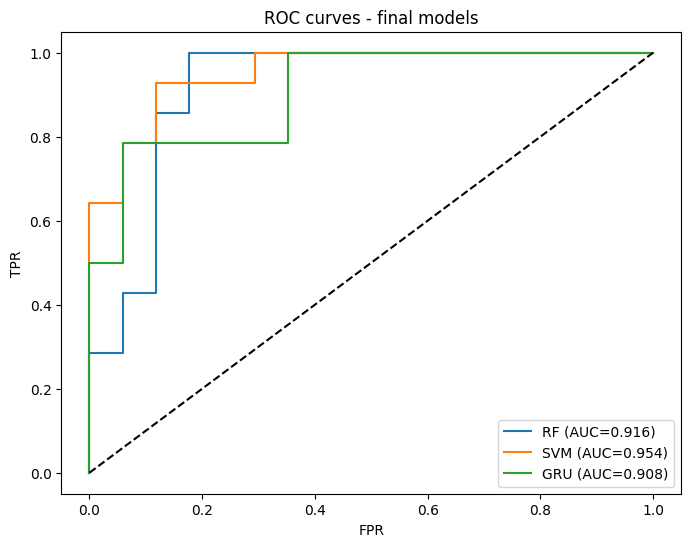

In [39]:
# Train final models on full dataset, then plot ROC on held-out test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=42)

best_rf.fit(X_train_full, y_train_full)
best_svm.fit(X_train_full, y_train_full)
# GRU
tf.keras.backend.clear_session()
gru_final = Sequential()
gru_final.add(InputLayer(input_shape=(X_train_full.shape[1],1)))
gru_final.add(GRU(32))
gru_final.add(Dropout(0.2))
gru_final.add(Dense(1, activation='sigmoid'))
gru_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_final.fit(X_train_full.to_numpy().reshape(len(X_train_full), X_train_full.shape[1],1),
              y_train_full.to_numpy(), epochs=40, batch_size=16, verbose=0)

# get probs
rf_p = best_rf.predict_proba(X_test_full)[:,1]
svm_p = best_svm.predict_proba(X_test_full)[:,1]
gru_p = gru_final.predict(X_test_full.to_numpy().reshape(len(X_test_full), X_test_full.shape[1],1)).ravel()

plt.figure(figsize=(8,6))
for name, probs in [('RF', rf_p), ('SVM', svm_p), ('GRU', gru_p)]:
    fpr, tpr, _ = roc_curve(y_test_full, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves - final models'); plt.legend()
plt.show()


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("Heart_disease_cleveland_new.csv")

# Clean dataset (same steps you used earlier)
df = df.dropna()

# Create X and y
X = df.drop("target", axis=1)
y = df["target"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dataset reloaded and X_scaled created successfully!")


Dataset reloaded and X_scaled created successfully!


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gru_model = keras.Sequential([
    layers.Input(shape=(X_scaled.shape[1], 1)),
    layers.GRU(32, return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("GRU model built successfully!")




GRU model built successfully!


In [13]:
import numpy as np

X_gru = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

print("X_gru shape:", X_gru.shape)


X_gru shape: (303, 13, 1)


In [14]:
history = gru_model.fit(X_gru, y, epochs=20, batch_size=16, verbose=1)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3003 - loss: 0.7233
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7723 - loss: 0.6486 
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7921 - loss: 0.5881 
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7987 - loss: 0.5272 
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7987 - loss: 0.4797 
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.4534 
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.4448 
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8152 - loss: 0.4381 
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8152 - loss: 0.4335 
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8152 - loss: 0.4263 
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8152 - loss: 0.4259 
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

In [41]:
import joblib
joblib.dump(gru_model, "best_gru.joblib")
print("GRU model saved successfully!")


GRU model saved successfully!


In [42]:
best_rf_model = joblib.load("best_rf.joblib")
best_svm_model = joblib.load("best_svm.joblib")
best_gru_model = joblib.load("best_gru.joblib")

print("All 3 models loaded successfully!")


All 3 models loaded successfully!


In [43]:
y_pred_gru_prob = best_gru_model.predict(X_gru)
y_pred_gru = (y_pred_gru_prob >= 0.5).astype(int).flatten()
cm_gru = confusion_matrix(y, y_pred_gru)
print(cm_gru)



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
[[ 30 134]
 [105  34]]


In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Heart_disease_cleveland_new.csv")

# Preprocessing
df = df.dropna()

X = df.drop("target", axis=1)
y = df["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dataset loaded and scaled.")


Dataset loaded and scaled.


In [49]:
df = pd.read_csv("Heart_disease_cleveland_new.csv").dropna()

# 1. One-hot encode
X = pd.get_dummies(df.drop("target", axis=1), drop_first=True)
y = df["target"]


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [52]:
best_rf_model.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,6
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
# 1. Predictions
y_pred = best_rf_model.predict(X_test_scaled)

# 2. Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[27  2]
 [ 5 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



In [56]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# 1. Train SVM model
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# 2. Predict
y_pred_svm = svm_model.predict(X_test_scaled)

# 3. Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
print(cm_svm)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Confusion Matrix:
[[27  2]
 [ 4 28]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [58]:
import numpy as np

X_train_gru = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_gru  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

gru_model = Sequential([
    GRU(32, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [60]:
history = gru_model.fit(
    X_train_gru, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6788 - loss: 0.6503 - val_accuracy: 0.7143 - val_loss: 0.6253
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7824 - loss: 0.6031 - val_accuracy: 0.7551 - val_loss: 0.5829
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7979 - loss: 0.5574 - val_accuracy: 0.7551 - val_loss: 0.5427
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8135 - loss: 0.5157 - val_accuracy: 0.7755 - val_loss: 0.5033
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8238 - loss: 0.4772 - val_accuracy: 0.7755 - val_loss: 0.4703
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8342 - loss: 0.4438 - val_accuracy: 0.7959 - val_loss: 0.4457
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8446 - loss: 0.4166 - val_accuracy: 0.8367 - val_loss: 0.4261
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.3963 - val_accuracy: 0.8163 - val_loss

In [61]:
# Probability output → convert to class labels (0 or 1)
y_pred_gru_prob = gru_model.predict(X_test_gru)
y_pred_gru = (y_pred_gru_prob > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


In [62]:
from sklearn.metrics import confusion_matrix, classification_report

cm_gru = confusion_matrix(y_test, y_pred_gru)
print("GRU Confusion Matrix:")
print(cm_gru)

print("\nGRU Classification Report:")
print(classification_report(y_test, y_pred_gru))


GRU Confusion Matrix:
[[25  4]
 [ 5 27]]

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



In [64]:
y_pred_rf = best_rf_model.predict(X_test_scaled)


In [65]:
y_pred_svm = svm_model.predict(X_test_scaled)


In [66]:
y_pred_gru_prob = gru_model.predict(X_test_gru)
y_pred_gru = (y_pred_gru_prob > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Random Forest
acc_rf  = accuracy_score(y_test, y_pred_rf)
pre_rf  = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)

# SVM
acc_svm = accuracy_score(y_test, y_pred_svm)
pre_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm  = f1_score(y_test, y_pred_svm)

# GRU
acc_gru = accuracy_score(y_test, y_pred_gru)
pre_gru = precision_score(y_test, y_pred_gru)
rec_gru = recall_score(y_test, y_pred_gru)
f1_gru  = f1_score(y_test, y_pred_gru)

comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "SVM", "GRU"],
    "Accuracy": [acc_rf, acc_svm, acc_gru],
    "Precision": [pre_rf, pre_svm, pre_gru],
    "Recall": [rec_rf, rec_svm, rec_gru],
    "F1-Score": [f1_rf, f1_svm, f1_gru]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.885246,0.931034,0.84375,0.885246
1,SVM,0.901639,0.933333,0.87500,0.903226
2,GRU,0.852459,0.870968,0.84375,0.857143
